# CNN_model1

mnist case
releated-link https://raw.githubusercontent.com/skyu0221/online-dropbox/master/ml/capstone2/train.csv


## Part 1 - understand a model

### Optimizers

Loss is the penalty for a bad prediction. That is, loss is a number indicating how bad the model's prediction was on a single example. If the model's prediction is perfect, the loss is zero; otherwise, the loss is greater than zero. The goal of training a model is to find a set of weights and biases (i.e. parameters) that have, on average, a low loss across all examples. The term cost is used interchangably with loss. See the [loss section](https://keras.io/losses/) in the Keras documentation for a list and descriptions of what is available.

![Side by side loss](https://drive.google.com/uc?id=1DdbQEQLCLCSw4uPsuf0C1nJCfUICT0Ae)
<b>Figure 1.</b> Left: high loss and right: low loss.

<!-- https://drive.google.com/file/d/1DdbQEQLCLCSw4uPsuf0C1nJCfUICT0Ae/view?usp=sharing
<img src="./fig/LossSideBySide.png" width="500">
<figcaption>Figure. Left: high loss and right: low loss.</figcaption>
 -->
The optimizer is the algorithm used to minimize the loss/cost. Optimizers in neural networks work by finding the gradient/derivative of the loss with respect to the parameters (i.e. the weights). "Gradient" is the correct term since a we are looking at multi-dimensional systems (i.e. many parameters), however, the terms are often used interchangably. For those who didn't take multivariate calculus, just think of the gradient as a derivative. The derivative of the loss with respect to a parameters tells us how much the loss changes when we nudge a weight up or down. So, by knowing how a given parameter affects the loss the optimizer can change it so as to decrease the loss. The various optimizers differ in how they change the weights. 

#### Mini-overview over popular optimizers

* **Stochastic Gradient Descent (SGD)**. This is the most basic and easy to understand optimizer. It updates the weights in the negative direction of the gradient by taking the average gradient of mini-batch of data (e.g. 20-1000 examples) in each step. Vanilla SGD only has one hyper-parameter, the learning rate.
* **Momentum**. This optimizer "gains speed" when the gradient has pointed in the same direction for several consecutive updates. That is, it has a momentum and want to keep moving in that direction. It gains momentum by accumulating an exponentially decaying moving average of past gradients. The step size depends on how large and aligned the sequence of gradients are. The most important hyper-parameter is alpha and common values are 0.5 and 0.9.
* **Nesterov Momentum**. This is a modification of the standard momentum optimizer.
* **AdaGrad**. This optimizer Ada-ptively sets the learning rate depending on the steepness/magnitude of the Grad-ients. This is done so that weights with big gradients get a smaller effective learning rate, and weights with small gradients will get a greater effective learning rate. The result is quicker progress in the more gently sloped directions of the weight space and a slowdown in stepp regions.
* **RMSProp**. This is modification of AdaGrad, where the accumulated gradient decays, that is, the influence of previous gradients gradually decreases.
* **Adam**. The name comes from "adaptive moments", and it is a combination of RMSProp and momentum. It has several hyper-parameters.

The above list just gives a quick overview of some of the most common. However, old optimizers are constantly improved and new are developed. SGD and momentum are most basic and easiest to understand and implement. They are still in use, but the more advanced optimizers tend to be better for practical use. Which one to use is generally an emperical question depending on both the data and the model.

For a more complete overview of optimization algorithms see [this comparison](http://ruder.io/optimizing-gradient-descent/), and to see what is available in Keras, see the [optimizer section](https://keras.io/optimizers/) of the documentation.

See the images below for a comparison of optimizers in a 2D space (NAG: Nesterov accelerated gradient, Adadelta: an extension of AdaGrad).

![Contours - optimizer comparison](https://drive.google.com/uc?id=1CmrD-UPZ7EIUjRuO_ib7k9CL1FO2bbLk)
<b>Figure 2.</b> Comparison of six different optimizers.


![Saddle point - optimizer comparison](https://drive.google.com/uc?id=1QVhN9rAvCjXtGyNZkmFivyyCzNsntObh)
<b>Figure 3.</b> Comparison of six different optimizers at a saddle point.

<!-- <img src="./fig/contours_evaluation_optimizers.gif" width="500">
<img src="./fig/saddle_point_evaluation_optimizers.gif" width="500"> -->

In [1]:
# imports
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
# for the random seed
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD

# set the random seeds to get reproducible results
np.random.seed(1)
tf.random.set_seed(2)

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X, y = X[:1000], y[:1000]
X = X.reshape(X.shape[0], 28, 28, 1)
# Normalize
X = X / 255.
# number of unique classes
num_classes = len(np.unique(y))
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

num_tot = y.shape[0]
num_train = y_train.shape[0]
num_test = y_test.shape[0]

y_oh = np.zeros((num_tot, num_classes))
y_oh[range(num_tot), y] = 1

y_oh_train = np.zeros((num_train, num_classes))
y_oh_train[range(num_train), y_train] = 1

y_oh_test = np.zeros((num_test, num_classes))
y_oh_test[range(num_test), y_test] = 1

In [2]:
X.shape

(1000, 28, 28, 1)

### Question 1
**The data set**

Plot a three examples from the data set.
* What type of data are in the data set?

    <span style="color:red"> < **numpy.ndarray** > </span>
    

* What does the line ```X = X.reshape(X.shape[0], 28, 28, 1)``` do?

  < make the X into 4D array which elements is 1000,28,28,1>

Look at how the encoding of the targets (i.e. ```y```) is changed. E.g. the lines
```
    y_oh = np.zeros((num_tot, num_classes))
    y_oh[range(num_tot), y] = 1
```
Print out a few rows of ```y``` next to ```y_oh```.
* What is the relationship between ```y``` and ```y_oh```?

    <span style="color:red"> <  **when the columns index in y_oh equal to y, then the value =1， otherwise value in y_oh euqal to 0** > </span>
    
    
* What is the type of encoding in ```y_oh``` called and why is it used?

    <span style="color:red"> <**one-hot encoding**> 
    </span>
    <**Because it transform y into the value between 0 and 1, which is suitable for the  equally categorical y**>
    
* Plot three data examples in the same figure and set the correct label as title. 
    * It should be possible to see what the data represent.

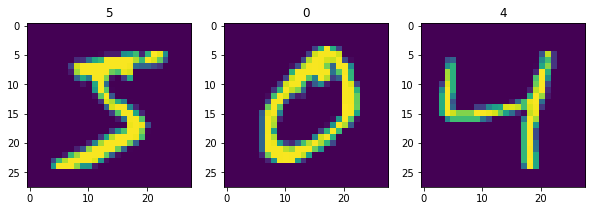

In [3]:
X_plot, y_plot = X[:3], y[:3]
X_plot=X_plot.reshape(3,28,28)
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,3,1)
plt.imshow(X_plot[0])
plt.title(y_plot[0])

fig.add_subplot(1,3,2)
plt.imshow(X_plot[1])
plt.title(y_plot[1])

fig.add_subplot(1,3,3)
plt.imshow(X_plot[2])
plt.title(y_plot[2])

plt.show()
#for i range(1,4):
#  img=X_plot[i]
#  fig.add_subplot(1,3,i)
#  plt.title(y[i])
#  plt.imshow(img)
#plt.show


# Question 2


To avoid the problem of overfitting, we need to artificially expand the data set. We can use existing data to generate 'fake data'. We add a small change to each picture on the built-in data:

* Randomly rotate some training images by 10 degrees
* Randomly Zoom by 10% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height

In [4]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

### Question 3
**The model**

Below is some code for bulding and training a model with Keras.
* What type of network is implemented below? I.e. a normal MLP, RNN, CNN, Logistic Regression...?

    <span style="color:red"> <***CNN***> </span>
    
    
* What does ```Dropout()``` do?

    <span style="color:red"> <***controll overfitting***> </span>


* Which type of activation function is used for the hidden layers?

    <span style="color:red"> <***Relu***> </span>


* Which type of activation function is used for the output layer?

    <span style="color:red"> <***Softmax***> </span>


* Why are two different activation functions used?

    <span style="color:red"> <***Different activation functions allow for different non-linearities which might work better for solving a specific function: ReLU is fast to compute so nice for deep networks with high training times; Softmax is used for multi-class classification problems and predict a multinomial probability distribution***> </span>


* What optimizer is used in the model below?

    <span style="color:red"> <***Stochastic Gradient Descent (SGD)***> </span>


* How often are the weights updated (i.e. after how many data examples)?

    <span style="color:red"> <**after the 32 samples, the weight will ungrades once**> </span>


* What loss function is used?

    <span style="color:red"> <***Categorical_crossentropy***> </span>


* How many parameters (i.e. weights and biases, NOT hyper-parameters) does the model have?

    <span style="color:red"> <***108,618***> </span>


In [5]:

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.))

model.add(Conv2D(32, (3, 3), activation='relu'))
# Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.))

model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=sgd)

# Train the model
model.fit(X_train, y_oh_train, batch_size=32, epochs=60)

# Evaluate performance
test_loss = model.evaluate(X_test, y_oh_test, batch_size=32)

predictions = model.predict(X_test, batch_size=32)
predictions = np.argmax(predictions, axis=1) # change encoding again
print('Accuracy:', (predictions == y_test).sum() / predictions.shape[0])

Epoch 1/60
25/25 [==============================] - 1s 17ms/step - loss: 2.2322
Epoch 2/60
25/25 [==============================] - 0s 18ms/step - loss: 1.3094
Epoch 3/60
25/25 [==============================] - 0s 20ms/step - loss: 0.5476
Epoch 4/60
25/25 [==============================] - 0s 20ms/step - loss: 0.3458
Epoch 5/60
25/25 [==============================] - 1s 20ms/step - loss: 0.2481
Epoch 6/60
25/25 [==============================] - 0s 20ms/step - loss: 0.1618
Epoch 7/60
25/25 [==============================] - 0s 20ms/step - loss: 0.1702
Epoch 8/60
25/25 [==============================] - 1s 20ms/step - loss: 0.1203
Epoch 9/60
25/25 [==============================] - 0s 18ms/step - loss: 0.0991
Epoch 10/60
25/25 [==============================] - 0s 17ms/step - loss: 0.0544
Epoch 11/60
25/25 [==============================] - 0s 19ms/step - loss: 0.0416
Epoch 12/60
25/25 [==============================] - 0s 17ms/step - loss: 0.0405
Epoch 13/60
25/25 [==================

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

## Part 3 - train a model

A model's performance depends on many factors apart from the model architecture (e.g. type and number of layers) and the dataset. Here you will get to explore some of the factors that affect model performance. Much of the skill in training deep learning models lies in quickly finding good values/options for these choises.

In order to observe the learning process it is best to compare the training set loss with the loss on the test set. How to visualize these variables with Keras is described under [Training history visualization](https://keras.io/visualization/#training-history-visualization) in the documentation.

You will explore the effect of 1) optimizer, 2) training duration, and 3) dropout (see the question above).

When training, an **epoch** is one pass through the full training set.



## Further information
For ideas about hyper-parameter tuning, take a look at the strategies described in the sklearn documentation under [model selection](https://scikit-learn.org/stable/model_selection.html), or in this [blog post](https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html) from TensorFlow. For a more thorough discussion about optimizers see [this video](https://www.youtube.com/watch?v=DiNzQP7kK-s) discussing the article [Descending through a Crowded Valley -- Benchmarking Deep Learning Optimizers](https://arxiv.org/abs/2007.01547).


**Good luck!**

### Question 1

* **Vizualize the training**. Use the model above to observe the training process. Train it for 150 epochs and then plot both "loss" and "val_loss" (i.e. loss on the valiadtion set, here the terms "validation set" and "test set" are used interchangably, but this is not always true). What is the optimal number of epochs for minimizing the test set loss? 
    * Remember to first reset the weights (this can be done by calling ```model.compile()```), otherwise the training just continues from where it was stopped earlier.

    <**Based on the graph showed from the first following code, the optimal number of epochs is around 15**>

In [7]:
def built_CNN(droupout):
  model = Sequential()
  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
  # Max pooling
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(droupout))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  # Max pooling
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(droupout))
  model.add(Dense(10, activation='softmax'))
  return model

In [ ]:
#Question: Vizualize the training
model=built_CNN(0)
model.compile(loss='categorical_crossentropy')
history=model.fit(X_train, y_oh_train, batch_size=32, epochs=150,validation_data=(X_test,y_oh_test))

plt.plot(history.history['val_loss'],label='test loss')
plt.plot(history.history['loss'], label='train loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
#the best epoch is 15, the maximum epoch can be up to 30

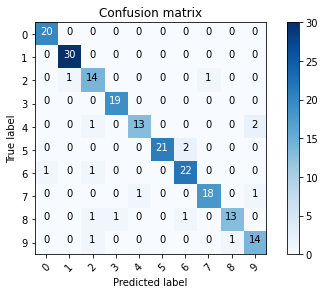

In [15]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_oh_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

<Figure size 1440x1440 with 0 Axes>

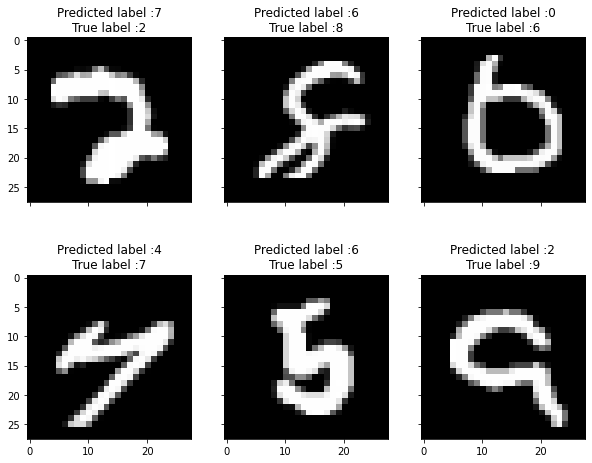

In [17]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    fig.set_size_inches(10, 8)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

plt.figure(figsize=(20, 20))
# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# Question2

* **Optimizer**. Select three different optimizers and for each find the close-to-optimal hyper-parameter(s). In your answer, include a) your three choises, b) best hyper-parameters for each of the three optimizers and, c) the code that produced the results.
    * *NOTE* that how long the training takes varies with optimizer. I.e., make sure that the model is trained for long enough to reach optimal performance.

    <**a) the three choices: SGD, Adam, RMSProp 
    b) hyper-parameters for each of the three optimizers can be shown from each search and the result as well.**>

In [ ]:
#!pip install -U keras-tuner
import tensorflow as tf
import kerastuner as kt
# Question: three optiomizer: SGD,Adam,RMSProp
# the hyper-parameter is based on page13 of the article 
# Descending through a Crowded Valley -- Benchmarking Deep Learning Optimizers.

#for SGD optimizer
def build_model(hp):
  model=built_CNN(0)
  model.compile(optimizer=tf.keras.optimizers.SGD(hp.Float('learning_rate', min_value=1e-4, max_value=1,sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

tuner = kt.Hyperband(build_model,objective='val_accuracy',max_epochs=30,project_name='SGD-1')
tuner.search(X_train, y_oh_train,epochs=15,validation_data=(X_test,y_oh_test))
tuner.results_summary()
# the accur is 0.949999988079071
#and the learning rate 0.18379900346409866

In [ ]:
# for Adam optimizer
def build_model(hp):
  model=built_CNN(0)
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1,sampling='log'),
                                                   hp.Float('beta1', min_value=0.5, max_value=0.999,sampling='log'),
                                                   hp.Float('beta2', min_value=0.8, max_value=0.999,sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

tuner = kt.Hyperband(build_model,objective='val_accuracy',max_epochs=30,project_name='Adam')
tuner.search(X_train, y_oh_train,epochs=15,validation_data=(X_test,y_oh_test))
tuner.results_summary()
#accuracy: 0.9599999785423279
#learning_rate: 0.00880194573492123
#beta1: 0.8059667512580438
#beta2: 0.818272724625341

In [ ]:
#for RMS prop optimizer
def build_model(hp):
  model=built_CNN(0)
  model.compile(optimizer=tf.keras.optimizers.RMSprop(hp.Float('learning_rate', min_value=1e-4, max_value=1, sampling='log'),
                                                      hp.Float('rho', min_value=1e-3, max_value=1, sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

tuner = kt.Hyperband(build_model,objective='val_accuracy',max_epochs=30,project_name='RMSprop')
tuner.search(X_train, y_oh_train,epochs=15,validation_data=(X_test,y_oh_test))
tuner.results_summary()
# the val_accuracy is 0.9649999737739563
# learning_rate: 0.017378972480895958
# rho: 0.011239435767055977

# Question3

* **Dropout**. Use the best optimizer and do hyper-parameter seach and find the best value for ```Dropout()```.

    <**the best optimizer is RMS Prop and the learning rate is 0.0174, the rho is 0.01124**>

In [ ]:
#Question: find the best value for Dropout()
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
def CNN(dropout):
  model=built_CNN(droupout=dropout)
#Compile the model
  RMSprop = tf.keras.optimizers.RMSprop(learning_rate=0.017378972480895958,rho=0.011239435767055977)
  model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=["accuracy"])
# Train the model
  return model

classifier = KerasClassifier(build_fn= CNN)
parameters = {'dropout':[0,0.25,0.5,0.75,0.9]}
grid_search = GridSearchCV(estimator = classifier,param_grid = parameters)
grid_search = grid_search.fit(X_train, y_oh_train,epochs=15,validation_data = (X_test,y_oh_test))
best_parameters = grid_search.best_params_
print(best_parameters)
# best parameters is 0.5

In [ ]:
# the result for douput search
import pandas as pd
pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

,dropout,Accuracy
0,0.00,0.90875
1,0.25,0.90750
2,0.50,0.91125
3,0.75,0.83625
4,0.90,0.38500


# Question4

* **Best model**. Combine the what you learned from the above three questions to build the best model. How much better is it than the worst and average models?

    <span style="color:red"> <**the accuracy in the best model is 0.915, the worst model is 0.59, the average one is 0.755**> </span>

In [ ]:
# Question: Best model: compare the best model with worst model, average model
#for the best model：depout=0.5,epochs=15,optimizer=RMSprop(learning_rate: 0.01737897,rho=rho=0.011239435767055977,accur_score=0.96)
model=built_CNN(0.5)
RMSprop = tf.keras.optimizers.RMSprop(learning_rate=0.017378972480895958,rho=0.011239435767055977)
model.compile(loss='categorical_crossentropy', optimizer=RMSprop)
model.fit(X_train, y_oh_train, batch_size=32, epochs=15)
predictions = model.predict(X_test, batch_size=32)
predictions = np.argmax(predictions, axis=1)
print('Accuracy:', (predictions == y_test).sum() / predictions.shape[0])
#accur: 0.915

Epoch 1/15
25/25 [==============================] - 1s 18ms/step - loss: 2.4598
Epoch 2/15
25/25 [==============================] - 0s 18ms/step - loss: 1.0114
Epoch 3/15
25/25 [==============================] - 0s 19ms/step - loss: 0.7831
Epoch 4/15
25/25 [==============================] - 0s 18ms/step - loss: 0.6503
Epoch 5/15
25/25 [==============================] - 0s 18ms/step - loss: 0.6528
Epoch 6/15
25/25 [==============================] - 0s 18ms/step - loss: 0.7504
Epoch 7/15
25/25 [==============================] - 0s 18ms/step - loss: 0.6909
Epoch 8/15
25/25 [==============================] - 0s 18ms/step - loss: 0.9260
Epoch 9/15
25/25 [==============================] - 0s 18ms/step - loss: 0.6351
Epoch 10/15
25/25 [==============================] - 0s 19ms/step - loss: 0.6558
Epoch 11/15
25/25 [==============================] - 0s 18ms/step - loss: 0.6920
Epoch 12/15
25/25 [==============================] - 0s 18ms/step - loss: 0.7351
Epoch 13/15
25/25 [==================

In [ ]:
# for the average model: drouput=0.75,epochs=43,optimizer=adam(learning_rate: 0.0065,beta1=0.5763,beta2=0.009668,accur_score=0.86), from previour running of three optimizer models
model=built_CNN(0.75)
adam=tf.keras.optimizers.Adam(learning_rate=0.0065,beta_1=0.05763, beta_2=0.09668)
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.fit(X_train, y_oh_train, batch_size=32, epochs=23)
predictions = model.predict(X_test, batch_size=32)
predictions = np.argmax(predictions, axis=1)
print('Accuracy:', (predictions == y_test).sum() / predictions.shape[0])
#accur: 0.755

Epoch 1/23
25/25 [==============================] - 1s 18ms/step - loss: 2.4009
Epoch 2/23
25/25 [==============================] - 0s 18ms/step - loss: 1.7752
Epoch 3/23
25/25 [==============================] - 0s 17ms/step - loss: 1.3729
Epoch 4/23
25/25 [==============================] - 0s 18ms/step - loss: 1.1287
Epoch 5/23
25/25 [==============================] - 0s 18ms/step - loss: 1.0517
Epoch 6/23
25/25 [==============================] - 0s 18ms/step - loss: 0.8927
Epoch 7/23
25/25 [==============================] - 0s 17ms/step - loss: 0.9042
Epoch 8/23
25/25 [==============================] - 0s 19ms/step - loss: 0.7722
Epoch 9/23
25/25 [==============================] - 0s 17ms/step - loss: 0.7155
Epoch 10/23
25/25 [==============================] - 0s 19ms/step - loss: 0.8163
Epoch 11/23
25/25 [==============================] - 0s 18ms/step - loss: 0.6652
Epoch 12/23
25/25 [==============================] - 0s 18ms/step - loss: 0.7522
Epoch 13/23
25/25 [==================

In [ ]:
# for the worst model: drouput=0.9 epochs=27 optimizer=SGD(learning_rate: 0.031045,accur_score=0.1), from previour running of three optimizer models
model=built_CNN(0.9)
sgd=tf.keras.optimizers.SGD(lr=0.031045)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_train, y_oh_train, batch_size=32, epochs=27)
predictions = model.predict(X_test, batch_size=32)
predictions = np.argmax(predictions, axis=1)
print('Accuracy:', (predictions == y_test).sum() / predictions.shape[0])
# accur=0.59

Epoch 1/27
25/25 [==============================] - 1s 19ms/step - loss: 2.7200
Epoch 2/27
25/25 [==============================] - 0s 19ms/step - loss: 2.2927
Epoch 3/27
25/25 [==============================] - 0s 18ms/step - loss: 2.2932
Epoch 4/27
25/25 [==============================] - 0s 18ms/step - loss: 2.2827
Epoch 5/27
25/25 [==============================] - 0s 18ms/step - loss: 2.2868
Epoch 6/27
25/25 [==============================] - 0s 18ms/step - loss: 2.2587
Epoch 7/27
25/25 [==============================] - 0s 18ms/step - loss: 2.2625
Epoch 8/27
25/25 [==============================] - 0s 18ms/step - loss: 2.2763
Epoch 9/27
25/25 [==============================] - 0s 18ms/step - loss: 2.2505
Epoch 10/27
25/25 [==============================] - 0s 19ms/step - loss: 2.2213
Epoch 11/27
25/25 [==============================] - 1s 20ms/step - loss: 2.2102
Epoch 12/27
25/25 [==============================] - 0s 19ms/step - loss: 2.2237
Epoch 13/27
25/25 [==================

# Question 4

* **Results on the test set**. When doing this search for good model configuration/hyper-parameter values, the data set was split into *two* parts: a training set and a test set (the term "validation" was used interchangably wiht "test"). For your final model, is the performance (i.e. accuracy) on the test set representative for the performance one would expect on a previously unseen data set (drawn from the same distribution)? Why?

    <span style="color:red"> <**the unseen data, drawn from the same distribution, has the similar feature with validation. Thus, the performance for the best model is representative for unseen data,as we can see from the data in between 1000 and 1100 from data code**> </span>

In [ ]:
#Question:Results on the test set--get the new data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X, y = X[1000:1100], y[1000:1100]
X = X.reshape(X.shape[0], 28, 28, 1)
# Normalize
X = X / 255.
# number of unique classes
num_classes = len(np.unique(y))
y = y.astype(int)
num_tot = y.shape[0]
y_oh = np.zeros((num_tot, num_classes))
y_oh[range(num_tot), y] = 1

In [ ]:
# for the best model
model=built_CNN(0.5)
RMSprop = tf.keras.optimizers.RMSprop(learning_rate=0.017378972480895958,rho=0.011239435767055977)
model.compile(loss='categorical_crossentropy', optimizer=RMSprop)
model.fit(X_train, y_oh_train, batch_size=32, epochs=15)
predictions = model.predict(X, batch_size=32)
predictions = np.argmax(predictions, axis=1)
print('Accuracy:', (predictions == y).sum() / predictions.shape[0])
#accur: 0.82

Epoch 1/15
25/25 [==============================] - 1s 19ms/step - loss: 2.3950
Epoch 2/15
25/25 [==============================] - 0s 18ms/step - loss: 0.9490
Epoch 3/15
25/25 [==============================] - 0s 18ms/step - loss: 0.7512
Epoch 4/15
25/25 [==============================] - 0s 17ms/step - loss: 0.6449
Epoch 5/15
25/25 [==============================] - 0s 18ms/step - loss: 0.6058
Epoch 6/15
25/25 [==============================] - 0s 18ms/step - loss: 0.7094
Epoch 7/15
25/25 [==============================] - 0s 18ms/step - loss: 0.6782
Epoch 8/15
25/25 [==============================] - 0s 17ms/step - loss: 0.7850
Epoch 9/15
25/25 [==============================] - 0s 18ms/step - loss: 0.6068
Epoch 10/15
25/25 [==============================] - 0s 18ms/step - loss: 0.6128
Epoch 11/15
25/25 [==============================] - 0s 18ms/step - loss: 0.7589
Epoch 12/15
25/25 [==============================] - 0s 19ms/step - loss: 0.6959
Epoch 13/15
25/25 [==================

In [ ]:
# for the worst model: drouput=0.9 epochs=27 optimizer=SGD(learning_rate: 0.031045,accur_score=0.1), from previour running of three optimizer models
model=built_CNN(0.9)
sgd=tf.keras.optimizers.SGD(lr=0.031045)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_train, y_oh_train, batch_size=32, epochs=27)
predictions = model.predict(X, batch_size=32)
predictions = np.argmax(predictions, axis=1)
print('Accuracy:', (predictions == y).sum() / predictions.shape[0])
# accur=0.66

Epoch 1/27
25/25 [==============================] - 1s 17ms/step - loss: 2.5105
Epoch 2/27
25/25 [==============================] - 0s 17ms/step - loss: 2.2885
Epoch 3/27
25/25 [==============================] - 0s 18ms/step - loss: 2.2951
Epoch 4/27
25/25 [==============================] - 0s 17ms/step - loss: 2.2786
Epoch 5/27
25/25 [==============================] - 0s 18ms/step - loss: 2.2695
Epoch 6/27
25/25 [==============================] - 0s 18ms/step - loss: 2.2702
Epoch 7/27
25/25 [==============================] - 0s 19ms/step - loss: 2.2469
Epoch 8/27
25/25 [==============================] - 0s 18ms/step - loss: 2.2231
Epoch 9/27
25/25 [==============================] - 0s 17ms/step - loss: 2.2266
Epoch 10/27
25/25 [==============================] - 0s 18ms/step - loss: 2.1580
Epoch 11/27
25/25 [==============================] - 0s 17ms/step - loss: 2.1434
Epoch 12/27
25/25 [==============================] - 0s 18ms/step - loss: 2.1354
Epoch 13/27
25/25 [==================